This routine is provided as an example on how to infer internal temperature
using the temperature measured from an RBRargo3 Argo.

As well as on an example profile from:
https://fleetmonitoring.euro-argo.eu/float/6903078

#### Import the required modules

In [1]:
from RBRargo3_TEMP_CNDC_from_TEMP_ADJUSTED import RBRargo3_TEMP_CNDC_from_TEMP_ADJUSTED
import numpy as np
import pandas as pd
import gsw
import matplotlib.pyplot as plt
%matplotlib inline

#### Example code

Uses a sample file retrieved from euro-argo

https://fleetmonitoring.euro-argo.eu/float/6903078

The sample file is a CSV file with the data from the 1nd profile for WMO6903078

Text(0.5, 1.0, 'Salinity error using TEMP CNDC (modeled)')

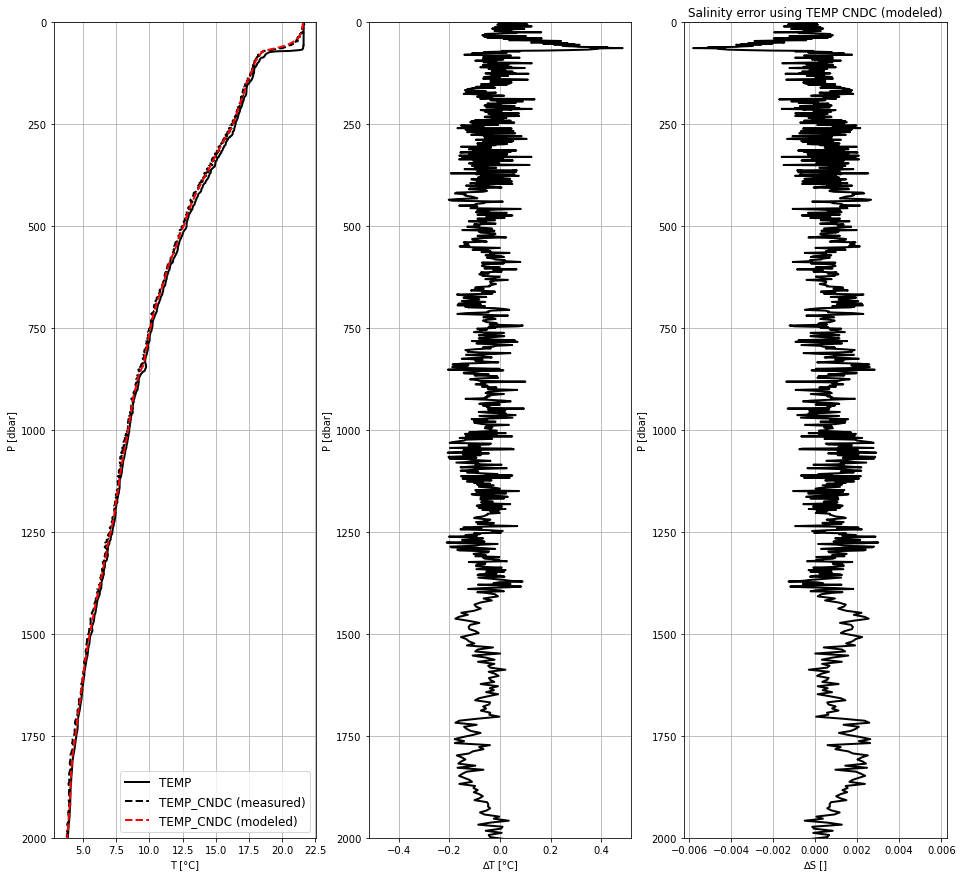

In [3]:
# Load the CSV file with example data
argo = pd.read_csv("../../test_data/6903078_testdata.csv")
argo.columns = ["PLATFORM_CODE", "DATEYYYYMMDDTHHMISSZ", "DATE_QC", "LATITUDEdegree_north", "LONGITUDEdegree_east", "POSITION_QC", "PRESdecibar", "PRES_QC", "PSALpsu", "PSAL_QC", "TEMPdegree_Celsius", "TEMP_QC", "PRES_ADJUSTEDdecibar", "PRES_ADJUSTED_QC", "TEMP_ADJUSTEDdegree_Celsius", "TEMP_ADJUSTED_QC", "PSAL_ADJUSTEDpsu", "PSAL_ADJUSTED_QC", "TEMP_CNDCdegree_Celsius", "TEMP_CNDC_QC"]
argo.astype = ["float64", "categorical", "float64", "float64", "float64", "float64", "float64", "float64", "float64", "double", "double", "double", "double", "double", "double", "double", "double", "double", "double", "double"]

#Simplify variables
PRES = argo['PRESdecibar'].to_numpy()
TEMP_CNDC_org = argo['TEMP_CNDCdegree_Celsius']
PSAL_ADJUSTED = argo['PSAL_ADJUSTEDpsu'].to_numpy()
TEMP_ADJUSTED_org = argo['TEMP_ADJUSTEDdegree_Celsius'].to_numpy()
PRES_ADJUSTED = argo['PRES_ADJUSTEDdecibar'].to_numpy()

# Infer conductivity from salinity, temperature, and pressure
COND = gsw.C_from_SP(PSAL_ADJUSTED, TEMP_ADJUSTED_org, PRES_ADJUSTED)

# Infers elptime using a nominal ascent rate of 10 cm/s
asentRate = 0.10 
elptime = (max(PRES_ADJUSTED) - PRES_ADJUSTED) / asentRate

# Sort the data chronologically
I = np.argsort(elptime)
elptime = elptime[I]
TEMP_ADJUSTED = TEMP_ADJUSTED_org[I]

TEMP_CNDC = RBRargo3_TEMP_CNDC_from_TEMP_ADJUSTED(TEMP_ADJUSTED, elptime)
TEMP_CNDC = np.flip(TEMP_CNDC)

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 15))

# Plot the measured and modeled temperature vs. pressure
axs[0].plot(TEMP_ADJUSTED_org, PRES, 'k', linewidth=2)
axs[0].plot(TEMP_CNDC_org, PRES, '--k', linewidth=2)
axs[0].plot(TEMP_CNDC, PRES, '--r', linewidth=2)
axs[0].grid(True)
axs[0].set_ylim([2000,0])
axs[0].set_ylabel('P [dbar]')
axs[0].set_xlabel('T [°C]')
axs[0].legend(['TEMP', 'TEMP_CNDC (measured)', 'TEMP_CNDC (modeled)'], loc='lower right', fontsize=12)

# Plot the difference between the measured and modeled TEMP CNDC
axs[1].plot(TEMP_CNDC_org - TEMP_CNDC, PRES, 'k', linewidth=2)
axs[1].invert_yaxis()
axs[1].grid(True)
axs[1].set_ylim([2000, 0])
axs[1].set_ylabel('P [dbar]')
axs[1].set_xlabel('∆T [°C]')
axs[1].set_xlim([-np.abs(axs[1].get_xlim()).max(), np.abs(axs[1].get_xlim()).max()])
#axs[1].set_title('Difference between measured and modeled TEMP CNDC')

# Plot the salinity error using TEMP CNDC (modeled)
ctcoeff = 1.4e-2
axs[2].plot(gsw.SP_from_C(COND, TEMP_ADJUSTED_org + ctcoeff*(TEMP_CNDC_org - TEMP_ADJUSTED_org), PRES_ADJUSTED) - 
             gsw.SP_from_C(COND, TEMP_ADJUSTED_org + ctcoeff*(TEMP_CNDC - TEMP_ADJUSTED_org), PRES_ADJUSTED),
            PRES_ADJUSTED,'k',linewidth=2)
axs[2].invert_yaxis()
axs[2].grid(True)
axs[2].set_ylim([2000, 0])
axs[2].set_ylabel('P [dbar]')
axs[2].set_xlabel('∆S []')
axs[2].set_xlim([-np.abs(axs[2].get_xlim()).max(), np.abs(axs[2].get_xlim()).max()])
axs[2].set_title('Salinity error using TEMP CNDC (modeled)')